In [1]:
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 43962, done.
remote: Total 43962 (delta 0), reused 0 (delta 0), pack-reused 43962
Receiving objects: 100% (43962/43962), 550.32 MiB | 31.06 MiB/s, done.
Resolving deltas: 100% (29958/29958), done.


In [2]:
%%shell
cd ..
ls

bin	 datalab  home	 lib64	opt   run   swift	       tmp    var
boot	 dev	  lib	 media	proc  sbin  sys		       tools
content  etc	  lib32  mnt	root  srv   tensorflow-1.15.2  usr


In [3]:
%cd ..
%ls

/
bin/      dev/   lib32/  opt/   sbin/   tensorflow-1.15.2/  var/
boot/     etc/   lib64/  proc/  srv/    tmp/
content/  home/  media/  root/  swift/  tools/
datalab/  lib/   mnt/    run/   sys/    usr/


In [4]:
!pip install tensorflow==1.15.0

     |████████████████████████████████| 412.3MB 43kB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
     |████████████████████████████████| 3.8MB 59.5MB/s 
     |████████████████████████████████| 512kB 52.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=59e753cc97a845ba9420aac727516a74ce4a8208251e9c8a20dc77e543ff32e1
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tens

In [5]:
%cd ..

!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install Cython
!pip install jupyter
!pip install matplotlib

%cd /content/models/research

!protoc object_detection/protos/*.proto --python_out=.

%set_env PYTHONPATH=/content/models/research:/content/models/research/slim

!python object_detection/builders/model_builder_test.py

/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
python-tk is already the newest version (2.7.17-1~18.04).
The following additional packages will be installed:
  python-bs4 python-chardet python-html5lib python-olefile
  python-pkg-resources python-six python-webencodings
Suggested packages:
  python-genshi python-lxml-dbg python-lxml-doc python-pil-doc python-pil-dbg
  python-setuptools
The following NEW packages will be installed:
  python-bs4 python-chardet python-html5lib python-lxml python-olefile
  python-pil python-pkg-resources python-six python-webencodings
0 upgraded, 9 newly installed, 0 to remove and 11 not upgraded.
Need to get 1,791 kB of archives.
After this operation, 7,807 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python-bs4 all 4.6.0-1 [67.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main a

In [6]:
!pip install tf_slim

     |████████████████████████████████| 358kB 8.8MB/s 


In [7]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# This is needed to display the images.
%matplotlib inline

In [8]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = '/content/models/research/object_detection/main_files/IG/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/content/images/labelmap.pbtxt'

#Number of classes
NUM_CLASSES = 1

In [9]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [10]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [11]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [12]:
def run_inference_for_single_image(image, graph):
    if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
    image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

    # Run inference
    output_dict = sess.run(tensor_dict,
                            feed_dict={image_tensor: np.expand_dims(image, 0)})

    # all outputs are float32 numpy arrays, so convert types as appropriate
    output_dict['num_detections'] = int(output_dict['num_detections'][0])
    output_dict['detection_classes'] = output_dict[
        'detection_classes'][0].astype(np.uint8)
    output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
    output_dict['detection_scores'] = output_dict['detection_scores'][0]
    if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [15]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/content/test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'testdoc_{}.jpg'.format(i)) for i in range(15, 40) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [16]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

FileNotFoundError: ignored

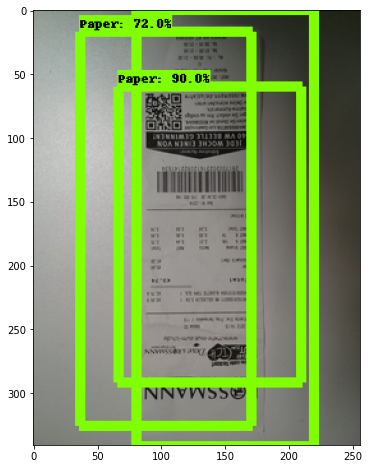

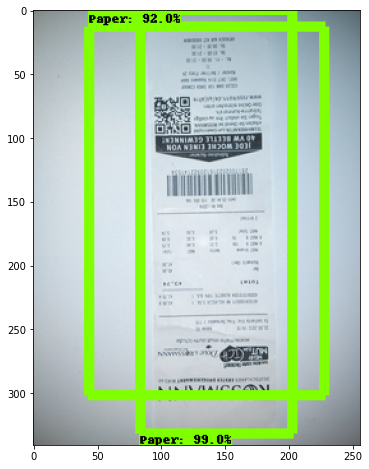

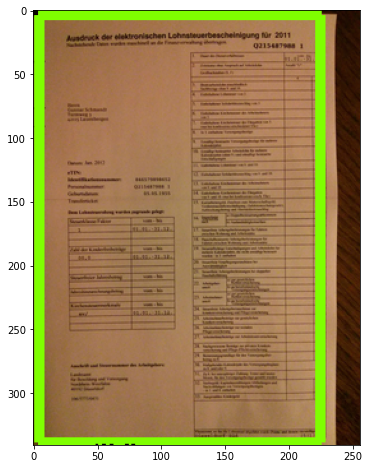

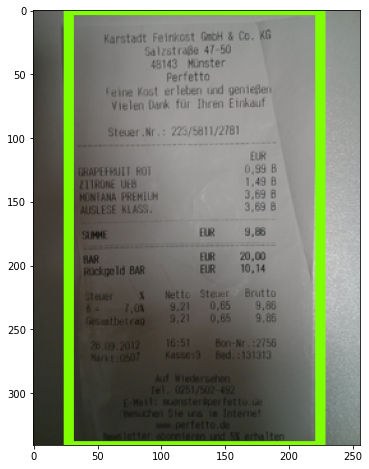

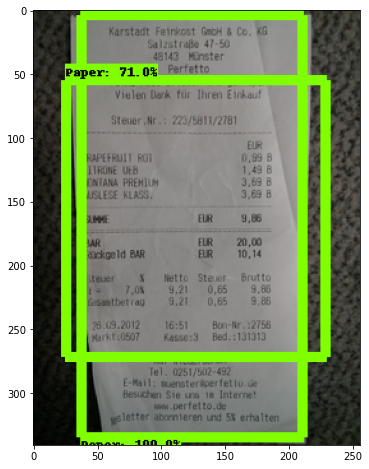

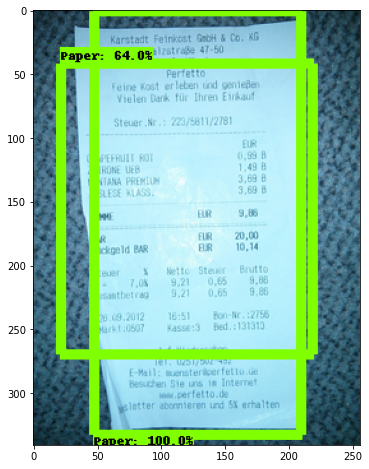

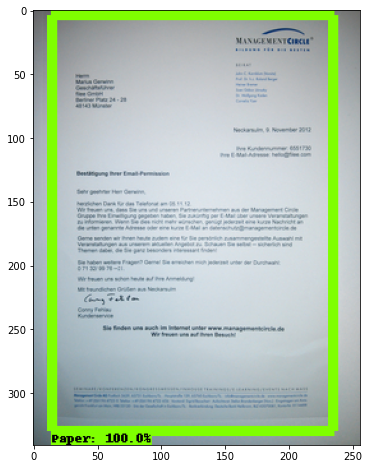

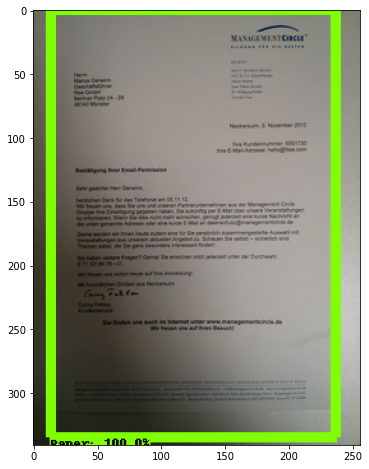

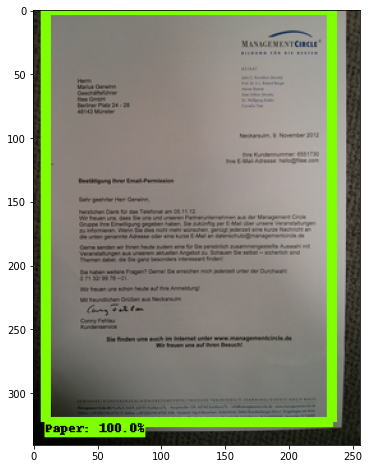

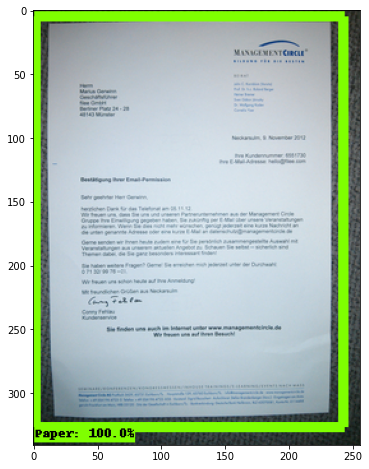

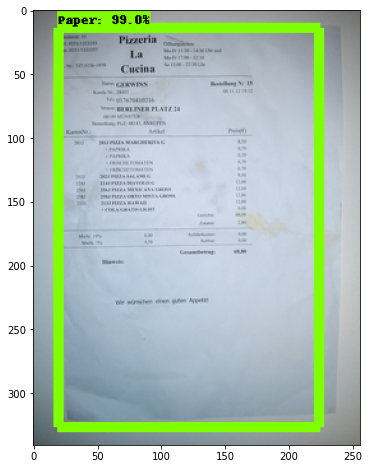

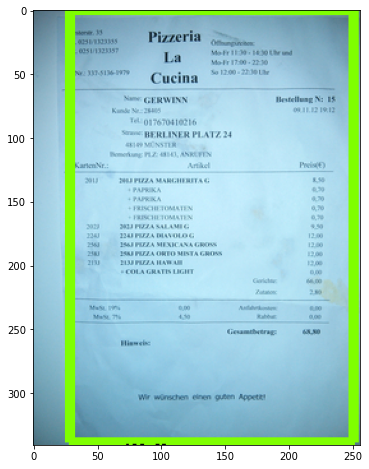

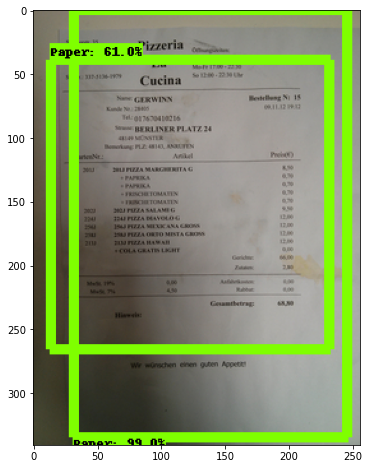

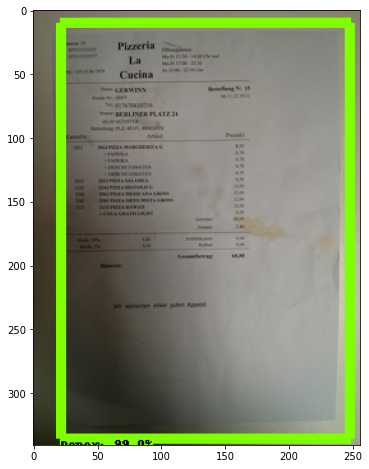

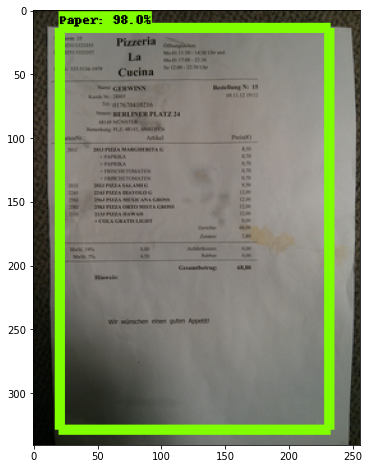

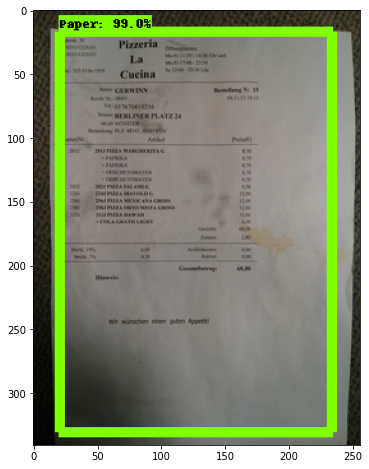

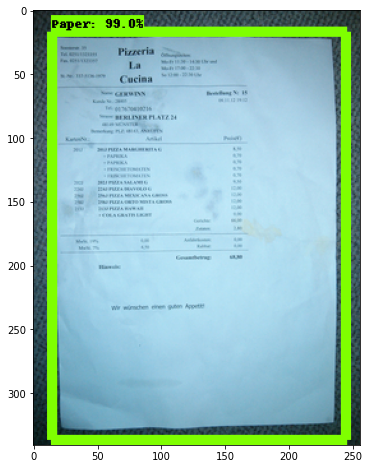

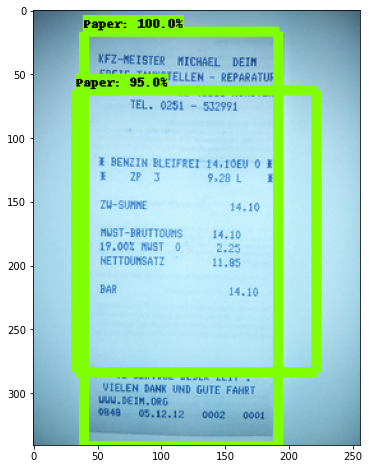

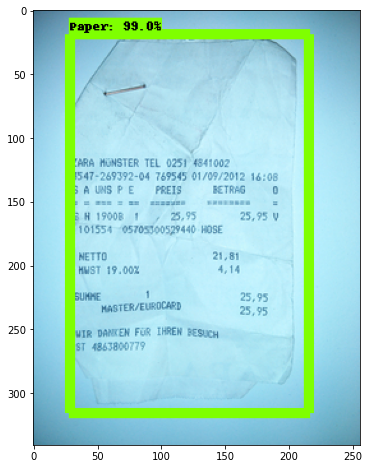

In [17]:

for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  fig = plt.figure(figsize=IMAGE_SIZE)
  ax = fig.gca()
  ax.grid(False)
  plt.imshow(image_np)